# Generate 2x2km grids on areas of interest

# Set Up

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
import sys
import numpy as np
import pandas as pd
import pandas_gbq as gbq

# Geospatial processing packages
import geopandas as gpd
from geowrangler import grids
from geowrangler.validation import GeometryValidation
from shapely import wkt
from shapely.geometry.polygon import orient

/home/avell/miniconda3/envs/site-scoring/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Util imports
sys.path.append("../../")  # include parent directory
from src.settings import CADT_BQ_ID, ADM1_BQ_ID, GRIDS_2K_BQ_ID, GCP_PROJ_ID

## Load Data

### CADT
Exclude all areas with official recognition of ancestral domain

In [5]:
# When running a query, note that there may be a one-time authentication required, just click on the link in the prompt and follow the auth steps
# Load CADT
cadt_query = f"""
  SELECT
  *
  FROM
  `{CADT_BQ_ID}`
  """
# convert from gbq table to gdf
cadt_df = gbq.read_gbq(cadt_query, "tm-geospatial", dialect="standard")
cadt_gdf = gpd.GeoDataFrame(
    cadt_df, geometry=cadt_df.geometry.apply(wkt.loads), crs="EPSG:4326"
)
cadt_gdf.head(2)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=Zp9wITwxCCyNruHQTVZu90PX30GG6u&access_type=offline


/home/avell/miniconda3/envs/site-scoring/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,CADT_NO_,SURVEY_NO_,LOCATION,AREA,geometry
0,1,0,"Bakun, Benguet","29,444.3449","POLYGON ((120.76500 16.72041, 120.76644 16.721..."
1,2,0,"Lanuza, San Miguel, Tandag & Tago, Surigao Del...","11,811.6247","POLYGON ((125.97530 9.17354, 125.96648 9.16946..."


<Axes: >

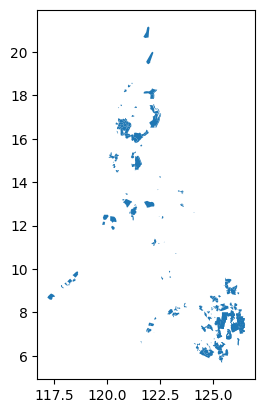

In [6]:
# visually inspect the cadt boundary
cadt_gdf.plot()

#### Geometry Validation

In [7]:
%%time
GeometryValidation(cadt_gdf)

cadt_gdf_val = GeometryValidation(cadt_gdf).validate_all()
cadt_gdf_val.head(2)

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 171 ms


,CADT_NO_,SURVEY_NO_,LOCATION,AREA,geometry,is_not_null,is_not_self_intersecting,is_oriented_properly,is_within_crs_bounds,area_is_not_zero
0,1,0,"Bakun, Benguet","29,444.3449","POLYGON ((120.76500 16.72041, 120.76644 16.721...",True,True,True,True,True
1,2,0,"Lanuza, San Miguel, Tandag & Tago, Surigao Del...","11,811.6247","POLYGON ((125.97530 9.17354, 125.96648 9.16946...",True,True,True,True,True


In [8]:
# check if any of the rows returned false in the tests
cadt_gdf_val[cadt_gdf_val.any(axis="columns") == False].shape

(0, 10)

In [10]:
# add uid for each row
cadt_gdf["id"] = (
    cadt_gdf[["CADT_NO_", "SURVEY_NO_", "LOCATION", "AREA"]].sum(axis=1).map(hash)
)
cadt_gdf.columns

Index(['CADT_NO_', 'SURVEY_NO_', 'LOCATION', 'AREA', 'geometry', 'id'], dtype='object')

### Admin bounds

In [11]:
# query for subset of adm_zone
adm_zone_query = f"""
  SELECT
    ADM1_PCODE,
    ADM1_EN,
    ADM2_PCODE,
    ADM2_EN,
    ADM3_PCODE,
    ADM3_EN,
    ADM4_PCODE,
    ADM4_EN,
    geometry
  FROM
  `{ADM1_BQ_ID}`
  """
# convert from adm_zone table to gdf
adm_df = gbq.read_gbq(adm_zone_query, "tm-geospatial", dialect="standard")
adm_gdf = gpd.GeoDataFrame(
    adm_df, geometry=adm_df.geometry.apply(wkt.loads), crs="EPSG:4326"
)
adm_gdf.head(2)

/home/avell/miniconda3/envs/site-scoring/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,geometry
0,PH010000000,Region I,PH012800000,Ilocos Norte,PH012802000,Bacarra,PH012802016,Natba,"MULTIPOLYGON (((120.58000 18.28157, 120.57713 ..."
1,PH010000000,Region I,PH012800000,Ilocos Norte,PH012802000,Bacarra,PH012802037,San Roque II (Pob.),"MULTIPOLYGON (((120.62244 18.24837, 120.62263 ..."


# Generate grids using geowrangler

## Remove CADT areas from admin bounds 

In [12]:
adm_diff = adm_gdf.overlay(cadt_gdf, how="symmetric_difference")
adm_diff.head(2)

/home/avell/miniconda3/envs/site-scoring/lib/python3.9/site-packages/geopandas/geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 700 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,CADT_NO_,SURVEY_NO_,LOCATION,AREA,id,geometry
0,PH010000000,Region I,PH012800000,Ilocos Norte,PH012802000,Bacarra,PH012802016,Natba,NaN,NaN,NaN,NaN,NaN,"POLYGON ((120.58000 18.28157, 120.57713 18.274..."
1,PH010000000,Region I,PH012800000,Ilocos Norte,PH012802000,Bacarra,PH012802037,San Roque II (Pob.),NaN,NaN,NaN,NaN,NaN,"POLYGON ((120.62244 18.24837, 120.62263 18.247..."


<Axes: >

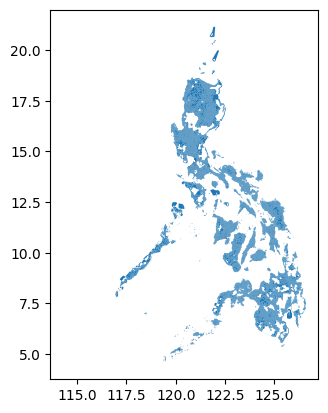

In [13]:
adm_diff.plot()

## Create grids

In [14]:
%%time
# set grid parameters
grid_generator = grids.SquareGridGenerator(2000)

# create grids
grid_gdf = grid_generator.generate_grid(adm_diff)
grid_gdf.head(2)

CPU times: user 2min 37s, sys: 1.38 s, total: 2min 38s
Wall time: 2min 39s


,x,y,geometry
0,288,0,"POLYGON ((119.45219 4.58729, 119.47015 4.58729..."
1,289,0,"POLYGON ((119.47015 4.58729, 119.48812 4.58729..."


In [15]:
grid_gdf.shape

(79982, 3)

<Axes: >

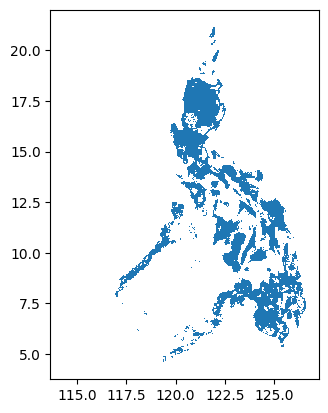

In [16]:
grid_gdf.plot()

In [17]:
# add admin info
grids_wadm = grid_gdf.sjoin(adm_diff, predicate="intersects")
grids_wadm.head(2)

,x,y,geometry,index_right,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,CADT_NO_,SURVEY_NO_,LOCATION,AREA,id
0,288,0,"POLYGON ((119.45219 4.58729, 119.47015 4.58729...",41162,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157011000,Sibutu,PH157011007,Ligayan,NaN,NaN,NaN,NaN,NaN
1,289,0,"POLYGON ((119.47015 4.58729, 119.48812 4.58729...",41162,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157011000,Sibutu,PH157011007,Ligayan,NaN,NaN,NaN,NaN,NaN


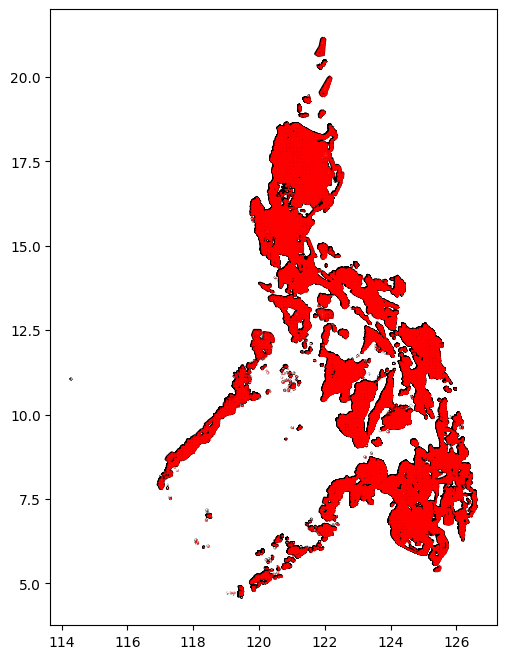

In [18]:
# Plot for sense checking
ax = adm_diff.plot(
    facecolor="none", edgecolor="black", legend=True, figsize=[8, 8], linewidth=2
)
ax = grids_wadm.plot(ax=ax, facecolor="none", edgecolor="red", alpha=0.5, linewidth=0.5)

In [19]:
grids_wadm

,x,y,geometry,index_right,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,CADT_NO_,SURVEY_NO_,LOCATION,AREA,id
0,288,0,"POLYGON ((119.45219 4.58729, 119.47015 4.58729...",41162,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157011000,Sibutu,PH157011007,Ligayan,NaN,NaN,NaN,NaN,NaN
1,289,0,"POLYGON ((119.47015 4.58729, 119.48812 4.58729...",41162,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157011000,Sibutu,PH157011007,Ligayan,NaN,NaN,NaN,NaN,NaN
4,288,2,"POLYGON ((119.45219 4.62311, 119.47015 4.62311...",41162,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157011000,Sibutu,PH157011007,Ligayan,NaN,NaN,NaN,NaN,NaN
5,288,3,"POLYGON ((119.45219 4.64102, 119.47015 4.64102...",41162,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157011000,Sibutu,PH157011007,Ligayan,NaN,NaN,NaN,NaN,NaN
2,284,1,"POLYGON ((119.38032 4.60520, 119.39829 4.60520...",34614,PH150000000,Autonomous Region in Muslim Mindanao,PH157000000,Tawi-Tawi,PH157005000,Sitangkai,PH157005004,Sitangkai Poblacion,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79974,657,286,"POLYGON ((126.08176 9.68413, 126.09972 9.68413...",39360,PH160000000,Region XIII,PH166700000,Surigao del Norte,PH166707000,Dapa,PH166707008,Corregidor,NaN,NaN,NaN,NaN,NaN
79976,660,289,"POLYGON ((126.13565 9.73725, 126.15362 9.73725...",34736,PH160000000,Region XIII,PH166700000,Surigao del Norte,PH166710000,General Luna,PH166710006,Daku,NaN,NaN,NaN,NaN,NaN
79977,661,288,"POLYGON ((126.15362 9.71954, 126.17159 9.71954...",34736,PH160000000,Region XIII,PH166700000,Surigao del Norte,PH166710000,General Luna,PH166710006,Daku,NaN,NaN,NaN,NaN,NaN
79978,661,289,"POLYGON ((126.15362 9.73725, 126.17159 9.73725...",34736,PH160000000,Region XIII,PH166700000,Surigao del Norte,PH166710000,General Luna,PH166710006,Daku,NaN,NaN,NaN,NaN,NaN


## Upload grids to bq

In [21]:
# define data type for geometry
table_schema = [
    {"name": "bing_id", "type": "STRING"},
    {"name": "x", "type": "NUMERIC"},
    {"name": "y", "type": "NUMERIC"},
    {"name": "ADM1_EN", "type": "STRING"},
    {"name": "ADM1_PCODE", "type": "STRING"},
    {"name": "ADM2_EN", "type": "STRING"},
    {"name": "ADM2_PCODE", "type": "STRING"},
    {"name": "ADM3_EN", "type": "STRING"},
    {"name": "ADM3_PCODE", "type": "STRING"},
    {"name": "ADM4_EN", "type": "STRING"},
    {"name": "ADM4_PCODE", "type": "STRING"},
    {"name": "geometry", "type": "GEOGRAPHY"},
]

gbq.to_gbq(
    grids_wadm,
    GRIDS_2K_BQ_ID,
    GCP_PROJ_ID,
    if_exists="fail",
    table_schema=table_schema,
    progress_bar=True,
    chunksize=10000,  # chunk the upload to stay within BQ limits
    api_method="load_csv",  # chunksize only works if load_csv (default is load_parquet)
)